In [1]:
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
import os

app_dir = os.path.join(os.getcwd(), "app")
load_dotenv(os.path.join(app_dir, ".env"))

loader = DirectoryLoader("./data", glob="**/*.txt")
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
chunks = text_splitter.split_documents(docs)

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


In [2]:
chunks[0]

Document(metadata={'source': 'data/restaurant.txt'}, page_content='In the charming streets of Palermo, tucked away in a quaint alley, stood Chef Amico, a restaurant that was more than a mere eatery—it was a slice of Sicilian heaven. Founded by Amico, a chef whose name was synonymous with passion and creativity, the restaurant was a mosaic of his life’s journey through the flavors of Italy.')

In [3]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

from ragas.testset import TestsetGenerator
from ragas.testset.synthesizers import default_query_distribution

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())


generator = TestsetGenerator(
    llm=generator_llm,
    embedding_model=generator_embeddings,
)

query_distribution = default_query_distribution(generator_llm)

testset = generator.generate_with_langchain_docs(
    documents=chunks,
    testset_size=8,
    query_distribution=query_distribution,
)


/Users/rh/Desktop/Workspace/Formations/IA/udemy-advanced-langChain/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Applying CustomNodeFilter:   0%|          | 0/22 [00:00<?, ?it/s]       Node fb3102b2-ac6a-4a69-8d92-1e4e2c2884d9 does not have a summary. Skipping filtering.
Node 8d45925e-9fc4-473b-a53f-f2e277a42ca2 does not have a summary. Skipping filtering.
Node d80b05ae-00ec-46a6-962e-455d33a1ab95 does not have a summary. Skipping filtering.
Node c9114403-b4a5-4eeb-9356-71dab32bda6b does not have a summary. Skipping filtering.
Node c7c7aafb-53a2-429d-9af5-1bb0f21aa06c does not have a summary. Skipping filtering.
Node 8058ab50-6239-475e-bef1-460bc8ec3cbb does not have a summary. Skipping filtering.
Node 5fd69651-e93e-4470-a5c8-3d1a16ff4701 does not have a summary. Skipping filtering.
Node 4619b2f

In [4]:
testset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What makes Chef Amico a notable restaurant in ...,"[In the charming streets of Palermo, tucked aw...",Chef Amico is notable because it is more than ...,single_hop_specifc_query_synthesizer
1,What kind of atmosphere does Chef Amico's rest...,[Chef Amico’s doors opened to a world where th...,Chef Amico’s restaurant offers a welcoming atm...,single_hop_specifc_query_synthesizer
2,Who is Elana Rosi and what was her mission at ...,"[One evening, as the sun cast a golden glow ov...",Elena Rossi is a renowned food critic who step...,single_hop_specifc_query_synthesizer
3,What are the prices and descriptions of panett...,[<1-hop>\n\npanettone; $15; traditional italia...,Panettone is a traditional Italian Christmas b...,multi_hop_abstract_query_synthesizer
4,What are the prices of calamari and margherita...,[<1-hop>\n\ncalamari; $12; fried squid rings w...,"The price of calamari is $12, and the price of...",multi_hop_abstract_query_synthesizer
5,what is the price of panettone and how does it...,[<1-hop>\n\npanettone; $15; traditional italia...,"The price of panettone is $15, while the margh...",multi_hop_abstract_query_synthesizer
6,How did Amico's upbringing in Palermo influenc...,[<1-hop>\n\nReturning to Palermo with a vision...,Amico's upbringing in Palermo significantly in...,multi_hop_specific_query_synthesizer
7,What makes Chef Amico a landmark in Palermmo a...,[<1-hop>\n\nReturning to Palermo with a vision...,Chef Amico is considered a landmark in Palermo...,multi_hop_specific_query_synthesizer
8,How does Chef Amico's connection to Sicily inf...,"[<1-hop>\n\nAs he grew, so did his desire to e...",Chef Amico's connection to Sicily profoundly i...,multi_hop_specific_query_synthesizer


In [5]:
from langchain_openai.embeddings import OpenAIEmbeddings

from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI

embedding = OpenAIEmbeddings()
model = ChatOpenAI(model="gpt-4o-mini")

vectorstore = Chroma.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [6]:
from langchain_core.prompts import PromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [7]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [8]:
# questions = testset.to_pandas()["question"].to_list()
# ground_truth = testset.to_pandas()["ground_truth"].to_list()

import pandas as pd

df = pd.read_csv("./questions_answers/qa.csv", delimiter=";")
questions = df["question"].tolist()
ground_truth = df["ground_truth"].tolist()

In [9]:
ground_truth

['Amico was born in the heart of the old quarter of Palermo.',
 "Amico was influenced by the cooking in his Nonna Lucia's kitchen.",
 "Amico learned to select the freshest fish and ripest fruits from Palermo's markets.",
 'Amico gained culinary experience across various regions in Italy, including Tuscany and Venice.',
 'Chef Amico is known for combining Sicilian and modern Italian cuisine.',
 "The menu reflects Amico's culinary journey and commitment to excellence.",
 "Amico sees hospitality as an art of celebrating life's simple pleasures.",
 "Chef Amico is distinguished by Amico's dedication and the community he nurtures.",
 'Amico mentors young chefs, conducts culinary workshops, and supports local producers.',
 "Amico's legacy lies in his community involvement and passion for food.",
 'Chef Amico is set in a quaint alley in Palermo.',
 'Chef Amico has a welcoming atmosphere with aromatic garlic and olive oil.',
 "The walls showcase Amico's travels and family recipes, representing 

In [10]:
from datasets import Dataset

data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data["question"].append(query)
    data["answer"].append(rag_chain.invoke(query))
    data["contexts"].append(
        [doc.page_content for doc in retriever.invoke(query)]
    )

dataset = Dataset.from_dict(data)

In [11]:
first_entry = {
    "question": data["question"][0],
    "answer": data["answer"][0],
    "contexts": data["contexts"][0],
    "ground_truth": data["ground_truth"][0],
}
first_entry

{'question': 'Where was Amico born?',
 'answer': 'The context does not specifically mention where Amico was born. However, it indicates that he was immersed in the art of Sicilian cooking and has strong ties to Palermo, suggesting that he may be from that area or associated with it.',
 'contexts': ['From a young age, Amico was immersed in the art of Sicilian cooking. His days were punctuated by visits to the bustling markets of Palermo, where he learned to choose the freshest fish from the Mediterranean and the ripest fruits kissed by the Sicilian sun. These experiences not only sharpened his culinary skills but also deepened his respect for the land and its bounty.',
  "Amico's life was deeply entwined with the vibrant essence of Sicilian cuisine. In the rustic kitchen where his Nonna conjured culinary magic, Amico found his calling. These formative years, filled with the rhythmic chopping of fresh herbs and the sizzling of rich tomato sauces, laid the foundation of his passion for co

In [12]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas import evaluate

from ragas.metrics import (
    Faithfulness,
    AnswerRelevancy,
    LLMContextRecall,
    LLMContextPrecisionWithReference,
    ContextRelevance,
)

from langchain_openai import ChatOpenAI, OpenAIEmbeddings

eval_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))
eval_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

metrics = [
    ContextRelevance(),
    LLMContextPrecisionWithReference(),
    LLMContextRecall(),
    Faithfulness(),
    AnswerRelevancy(),
]

In [13]:
result = evaluate(
    dataset=dataset,
    metrics=metrics,
    llm=eval_llm,
    embeddings=eval_embeddings
)

print(result)

Evaluating: 100%|██████████| 150/150 [00:53<00:00,  2.79it/s]


{'nv_context_relevance': 0.9500, 'llm_context_precision_with_reference': 0.7463, 'context_recall': 0.9000, 'faithfulness': 0.9180, 'answer_relevancy': 0.8762}


In [14]:
result.to_pandas()

,user_input,retrieved_contexts,response,reference,nv_context_relevance,llm_context_precision_with_reference,context_recall,faithfulness,answer_relevancy
0,Where was Amico born?,"[From a young age, Amico was immersed in the a...",The context does not specifically mention wher...,Amico was born in the heart of the old quarter...,1.0,0.250000,0.0,0.600000,0.000000
1,What was Amico's early culinary influence?,"[From a young age, Amico was immersed in the a...",Amico's early culinary influence came from his...,Amico was influenced by the cooking in his Non...,1.0,0.500000,1.0,1.000000,0.976923
2,What skill did Amico learn from Palermo's mark...,"[From a young age, Amico was immersed in the a...",Amico learned to choose the freshest fish from...,Amico learned to select the freshest fish and ...,1.0,0.916667,1.0,1.000000,0.895589
3,Where in Italy did Amico gain culinary experie...,"[As he grew, so did his desire to explore beyo...",Amico gained culinary experience in various re...,Amico gained culinary experience across variou...,1.0,1.000000,1.0,1.000000,0.974451
4,"What is ""Chef Amico"" restaurant known for?","[Today, Chef Amico stands as a landmark in Pal...","""Chef Amico"" restaurant is known for being a s...",Chef Amico is known for combining Sicilian and...,1.0,0.000000,0.0,1.000000,0.999999
5,What does Amico's restaurant menu reflect?,"[At Chef Amico, every dish told a story. The m...",Amico's restaurant menu reflects his journey a...,The menu reflects Amico's culinary journey and...,1.0,1.000000,1.0,1.000000,0.999999
6,How does Amico perceive hospitality?,"[At Chef Amico, every dish told a story. The m...","Amico perceives hospitality as an art form, be...",Amico sees hospitality as an art of celebratin...,1.0,1.000000,1.0,1.000000,1.000000
7,"What distinguishes ""Chef Amico"" in Palermo?","[Today, Chef Amico stands as a landmark in Pal...","""Chef Amico"" is distinguished in Palermo by it...",Chef Amico is distinguished by Amico's dedicat...,1.0,0.833333,1.0,1.000000,0.969536
8,What activities does Amico engage in besides c...,"[From a young age, Amico was immersed in the a...","Besides cooking, Amico engages in mentoring yo...","Amico mentors young chefs, conducts culinary w...",1.0,0.250000,1.0,1.000000,1.000000
9,How is Amico's legacy beyond his dishes?,[Amico’s legacy is not just in the dishes he c...,Amico's legacy extends beyond his dishes throu...,Amico's legacy lies in his community involveme...,1.0,0.833333,1.0,0.928571,0.926426


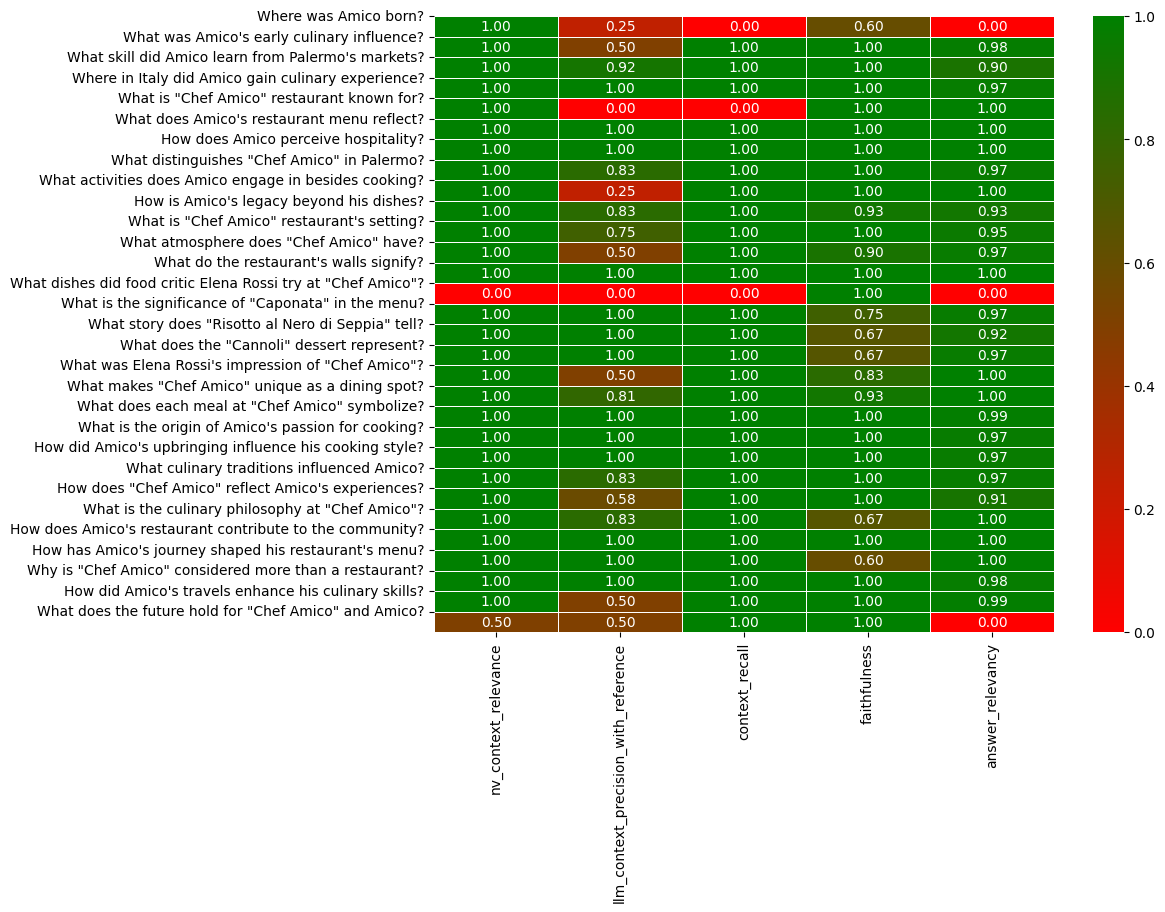

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

heatmap_data = df[
    [
        "nv_context_relevance",
        "llm_context_precision_with_reference",
        "context_recall",
        "faithfulness",
        "answer_relevancy",
    ]
]

cmap = LinearSegmentedColormap.from_list("green_red", ["red", "green"])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=0.5, cmap=cmap)

plt.yticks(ticks=range(len(df["user_input"])), labels=df["user_input"], rotation=0)

plt.show()